## imports

In [32]:
import pandas as pd
from pandas import DataFrame
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import os
import re
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

from typing import List

In [2]:
import plotly.io as pio

pio.renderers.default = 'browser'

## Carregando dados

In [21]:
def get_data_index(timestep=0):
    files = os.listdir('pops3')

    files_data = [file for file in files if re.search(r'Data', file)]
    files_index = [file for file in files if re.search(r'Ids', file)]

    # Ordena arquivos por timestep (numero pós o "t")
    files_data = sorted(files_data, key=lambda x: int(x.split('t')[1].split()[0]))
    files_index = sorted(files_index, key=lambda x: int(x.split('t')[1].split()[0]))


    current_df = pd.read_csv(f'pops3/{files_data[timestep]}', sep='\t', header=None)
    current_df.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

    current_df_indexes = pd.read_csv(f'pops3/{files_index[timestep]}', sep='\t', header=None)
    current_df_indexes.columns = ['ancestral', 'id']

    current_df['id'] = current_df_indexes['id']

    
    return current_df, current_df_indexes


In [25]:
data, index = get_data_index(timestep=10)

In [26]:
data

,a,b,c,d,e,f,g,h,i,j,id
0,2.43102,-5.10363,4.19179,3.03037,-3.30818,-2.49360,2.69583,4.60896,-0.63564,-5.36439,1
1,-6.24984,-4.05154,3.50351,3.52534,-3.44175,-3.38966,-4.72292,-2.16082,-3.52027,-4.06767,2
2,-4.03141,-4.75464,-2.62887,-4.52095,-1.26427,-2.31962,2.79425,-3.19461,-3.05889,-3.63173,3
3,2.73332,-1.83434,-3.48935,3.57565,6.33370,1.80881,4.71284,2.91752,4.69356,4.27391,4
4,-3.50568,4.60009,4.86498,3.15577,4.15590,2.72134,-3.27626,3.75862,4.72451,-2.58930,5
...,...,...,...,...,...,...,...,...,...,...,...
1995,3.20039,-1.60146,-3.64028,-2.87016,-5.18239,4.59655,3.72156,-4.05901,-4.70278,2.74150,1996
1996,-3.13230,3.08192,-4.48173,-2.94267,4.85203,1.98730,-2.58605,-2.41194,-3.83327,-4.21952,1997
1997,1.90702,1.29469,-3.71221,-4.14376,-1.17726,-2.95181,-4.00854,2.22778,-0.86818,-4.21909,1998
1998,-2.87437,-1.54905,-1.98366,3.79311,-3.13998,-4.50066,-4.36642,3.81207,4.55173,-2.89036,1999


In [27]:
index

,ancestral,id
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
1995,0,1996
1996,0,1997
1997,0,1998
1998,0,1999


## Entendendo o problema

Possuímos 2 datasets, data e index:

- data: possui 10 colunas, onde cada linha é um indivíduo e cada coluna é uma característica genética daquele indivíduo.
- index: possui 2 colunas, a primeira coluna é o identificador do ancestral e a segunda coluna é o identificador do indivíduo.

Não temos controle sobre as populações, no sentido de que não conseguimos determinar o processo de surgimento de uma população em detrimento da outra, pois para isso, teriamos que realizar uma análise a nível de inidivíduo, o que não é possível, visto que noss ograu de granularidade máximo é a população, por isso, devemos abstrair esse processo e entender que isso virá a partir dos dados.

Vamos analizar como nossas populações se comportam no instante inicial

In [49]:
'''Para fazer essa análise utilizaremos o TSNE, que de maneira simplesmaximiza a similaridade entre a distribuição de probabilidade dos pares de pontos de dados no espaço original e os pares de pontos de dados no novo espaço (de dimensão menor). Com isso, temos uma redução da dimensionalidade original dos dados.

Contudo, não podemos usar o resultado do TSNE apenas utilizar para visualização. Ainda assim, não é desejado utilizar nenhuma técnica de redução de dimensionalidade, pois queremos manter o espaço gênico previamente definido.'''


def plot_tsne(data: DataFrame, perplexity : int =30, learning_rate: int =200):
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    df_tsne = tsne.fit_transform(data.drop(columns='id'))

    # Convertendo o resultado para um DataFrame
    df_tsne = pd.DataFrame(df_tsne, columns=['TSNE_1', 'TSNE_2'])

    # Plotando os dados transformados
    plt.figure(figsize=(10, 6))
    plt.scatter(df_tsne['TSNE_1'], df_tsne['TSNE_2'])
    plt.xlabel("TSNE 1")
    plt.ylabel("TSNE 2")
    plt.title("Visualização t-SNE de um DataFrame Genérico")
    plt.show()

In [50]:
data, index = get_data_index(timestep=0)

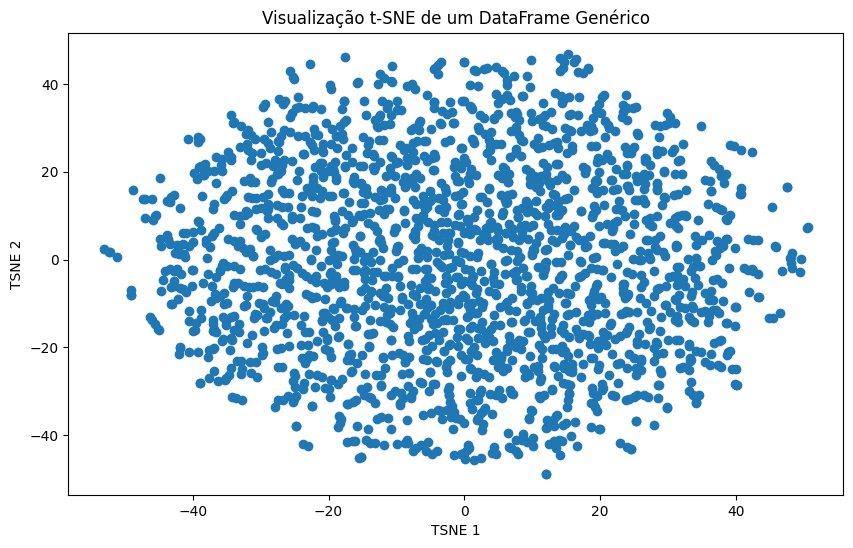

In [51]:
plot_tsne(data)

Como será que as populações se distanciam com o passar dos anos? Vamos visualizar

In [52]:
data, _ = get_data_index(timestep=100)

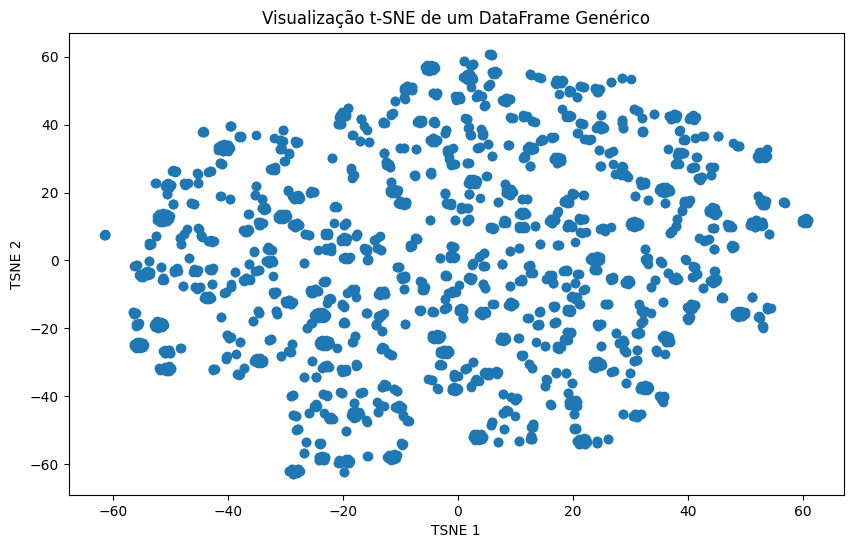

In [53]:
plot_tsne(data)

Claro que como se trata de uma redução de dimensionalidade, o resultado visto não necessariamente reproduz a realidade, mas é um bom indicativo, onde podemos ver que de fato ocorre um afastamento das populações

O principal objetivo aqui é tentar retirar a informação do número de espécies existentes, a partir das populações. Assim, o número de espécies será dado a partir do resultado da clusterização, o que nos leva a pensar em alguns pontos.


Se temos um dataset para cada espaço de tempo definido, com possíveis números diferentes de espécies em cada um desses espaços, faremos a clusterização da seguinte forma:

Para o step atual, considerando n espécies, a clusterização será realizada deveria ser realizada dentro de cada espécie e em cada espaço de tempo. 


Assim, para cada espaço de tempo é necessário que tenhamos salvo a qual espécie (cluster) cada população pertence. Porém, podemos ter espécies que são extintas, ou novas espécies que surgem de espécies existentes, para lidar com esse problema fazermos o seguinte: sempre que tivermos uma nova população, ela será posta em um cluster diferente, e sempre que uma população for extinta, ela será posta no cluster de sua espécie pai.

Outro ponto, é que se iremos propagar os clusters para cada espaço de tempo, devemos salvar sempre um esquema de mapeamento, onde teremos as populações e as respectivas espécies.
Outro ponto é que precisamos realizar a clusterização em cima dos dados completos no primeiro instante de tempo para que possamos ter um ponto de partida para a clusterização dos próximos instantes de tempo.
    

## Clusterização

Primariamente, utilizaremos como modelo o DBSCAN (com parâmetrização sugerida) para realizar a clusterização. A escolha do algoritmo e parâmetros faz sentido por alguns aspectos:

1. Não é necessário informar a quantidade de clusters (o que é um ponto positivo, pois não sabemos a quantidade de espécies)
2. A escolha de MinPoints = 1 faz todo sentido, pois não existem outliers no nosso problema, uma população que se afasta das demais não deveria ser considerada um outlier, e sim uma nova espécie (o que acontecerá).

### Gerando as primeiras espécies

In [116]:
def plot_clusters(data: DataFrame, perplexity: int= 30, learning_rate: int =200):
    if 'Cluster' not in data.columns:
        print('A coluna de cluster não foi encontrada')
        return
    
    clusters = data['Cluster']

    num_clusters = len(set(clusters))
    print(f"Número de Espécies: {num_clusters}")

    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=42)
    df_tsne = tsne.fit_transform(data.drop(columns='id'))
    df_tsne = pd.DataFrame(df_tsne, columns=['TSNE_1', 'TSNE_2'])
    df_tsne['Cluster'] = clusters

    markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'h', 'x', '8']

    plt.figure(figsize=(10, 6))
    for cluster_id in sorted(df_tsne['Cluster'].unique()):
        cluster_data = df_tsne[df_tsne['Cluster'] == cluster_id]
        marker = markers[cluster_id % len(markers)]  # Cicla entre os marcadores se houver muitos clusters
        plt.scatter(cluster_data['TSNE_1'], cluster_data['TSNE_2'], label=f'Espécie {cluster_id}', marker=marker)

    plt.xlabel("TSNE 1")
    plt.ylabel("TSNE 2")
    plt.title(f"Espécies identificados pelo DBSCAN após Redução de Dimensionalidade com t-SNE")
    plt.legend(title="Espécies")
    plt.show()

In [117]:
data, _ = get_data_index(timestep=0)

In [118]:
dbscan = DBSCAN(eps=50, min_samples=1)
clusters = dbscan.fit_predict(data.drop(columns='id', errors='ignore'))

data['Cluster'] = clusters

Número de Espécies: 1


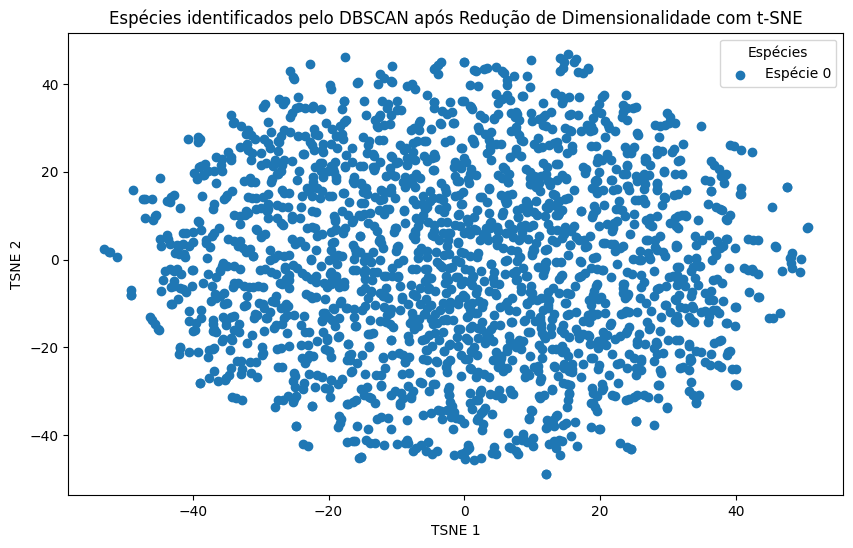

In [119]:
plot_clusters(data)

Em um momento inicial, foi visto que só possuímos uma espécie (cluster), vamos criar uma memória e salvar essas informações ao longo do tempo. Lembrando que para cada novo cluster (espécie), reaplicaremos a clusterização somente nesse cluster

#### Criando memória para salvar as espécies ao longo do tempo

A memória consistirá de um dataframe para cada instante de tempo contendo as espécies e seus respectivos clusters. Poderia ser feito em um único dataframe, mas queremos realizar uma visualização desses dados ao longo do tempo, então é mais interessante ter um dataframe para cada instante de tempo. 

In [224]:
'''Como a parte da memória é um pouco mais sensível, vamos criar uma classe para controlar essa questão'''


import os


class SpecieMemory:
    def __init__(self, file_name : str = 'especies', data_folder : str = 'SpecieMemory'):
        self.timestep = 0
        
        self.data_folder = data_folder

        if not os.path.exists(self.data_folder): # Cria a pasta caso não exista
            os.makedirs(self.data_folder)
        
        self.file_name = file_name
        self.file_path = data_folder + '/' + file_name + str(self.timestep) + '.csv'
        
        self.memory = self.load_memory()
        
    
    def load_memory(self):
        if os.path.isfile(self.file_path):
            return pd.read_csv(self.file_path)
        else:
            df = pd.DataFrame(columns=['id', 'Cluster'])
            df.to_csv(self.file_path, index=False)
            return df


    def get_memory(self, timestep: int = None):
        if timestep is None:
            return self.memory  # Retorna a memória atual

        specific_file_path = os.path.join(self.data_folder, f"{self.file_name}{timestep}.csv")
        print(specific_file_path)

        try:
            if os.path.isfile(specific_file_path):
                return pd.read_csv(specific_file_path)
            else:
                print(f"Timestep {timestep} não encontrado.")
                return None
        except Exception as e:
            print(f"Erro ao carregar o timestep {timestep}: {e}")
            return None
        
    
    def post_memory(self, data : DataFrame):
        if 'Cluster' not in data.columns:
            print('A coluna de cluster não foi encontrada')
            return
        
        clusters = data['Cluster']
        index = data['id']
        
        data_memory = pd.DataFrame({'id': index, 'Cluster': clusters})
        
        self.memory = data_memory
        self.timestep += 1
        self.file_path = os.path.join(self.data_folder, f"{self.file_name}{self.timestep}.csv")
        
        data_memory.to_csv(self.file_path, index=False)
        
        
    def reset_all(self):
        self.timestep = 0

        for file in os.listdir(self.data_folder):
            if file.startswith(self.file_name) and file.endswith(".csv"):
                os.remove(os.path.join(self.data_folder, file))

        self.memory = pd.DataFrame(columns=['id', 'Cluster'])
        self.file_path = os.path.join(self.data_folder, f"{self.file_name}{self.timestep}.csv")
        self.memory.to_csv(self.file_path, index=False)
        print("Memória resetada e todos os arquivos anteriores foram removidos.")
        

In [225]:
memory = SpecieMemory()

In [226]:
print(memory.get_memory())

Empty DataFrame
Columns: [id, Cluster]
Index: []


In [227]:
memory.timestep

0